In [1]:
# auto update python files
%load_ext autoreload

In [8]:
%autoreload 2

In [6]:
# import libraries
import sys
sys.path.append('../tracking_validation/')

In [19]:
import numpy as np
from utils import *
from association_gate import association_gate
#from temp_csv_parser import *


In [22]:
from load_association_params import AssociationParams
params = AssociationParams("/home/yoshiri/autoware/src/universe/autoware.universe/perception/multi_object_tracker/config/data_association_matrix.param.yaml")
params.getAssociationParams("CAR", "CAR")

[2.0, 3.6, 12.1, 1.047, 0.1]

In [24]:
# load csv data
import pandas as pd
csv_file = "/home/yoshiri/tracker_data.csv"
csv_data = pd.read_csv(csv_file)

# print column names
print(csv_data.columns)

Index(['__time',
       '/perception/object_recognition/detection/objects/header/stamp',
       '/perception/object_recognition/detection/objects/objects.0/classification.0/label',
       '/perception/object_recognition/detection/objects/objects.0/classification.0/probability',
       '/perception/object_recognition/detection/objects/objects.0/existence_probability',
       '/perception/object_recognition/detection/objects/objects.0/kinematics/has_position_covariance',
       '/perception/object_recognition/detection/objects/objects.0/kinematics/has_twist',
       '/perception/object_recognition/detection/objects/objects.0/kinematics/has_twist_covariance',
       '/perception/object_recognition/detection/objects/objects.0/kinematics/orientation_availability',
       '/perception/object_recognition/detection/objects/objects.0/kinematics/pose_with_covariance/covariance.0',
       ...
       '/perception/object_recognition/tracking/objects/objects.2/shape/dimensions/x',
       '/perceptio

In [29]:
from autoware_auto_perception_msgs.msg import DetectedObject
from autoware_auto_perception_msgs.msg import TrackedObject
from autoware_auto_perception_msgs.msg import DetectedObjectKinematics
from autoware_auto_perception_msgs.msg import ObjectClassification
from autoware_auto_perception_msgs.msg import Shape

testobj = DetectedObject()

In [61]:
detected_obj_names = [
    "/perception/object_recognition/detection/objects/objects.0/",
    "/perception/object_recognition/detection/objects/objects.1/",
    "/perception/object_recognition/detection/objects/objects.2/",
]


# get corresponding pose with covariance from csv data
def getDetectedObject(df, obj_name):
    obj = DetectedObject()

    try:
        # classification
        classification = ObjectClassification()
        classification.label = int(df[obj_name + "classification.0/label"])
        classification.probability = df[obj_name + "classification.0/probability"].astype(float)
        obj.classification = [classification]
        obj.existence_probability = df[obj_name + "existence_probability"].astype(float)
        obj.kinematics = DetectedObjectKinematics()
        obj.kinematics.pose_with_covariance.pose.position.x = df[obj_name + "kinematics/pose_with_covariance/pose/position/x"].astype(float)
        obj.kinematics.pose_with_covariance.pose.position.y = df[obj_name + "kinematics/pose_with_covariance/pose/position/y"].astype(float)
        obj.kinematics.pose_with_covariance.pose.position.z = df[obj_name + "kinematics/pose_with_covariance/pose/position/z"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.x = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/x"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.y = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/y"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.z = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/z"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.w = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/w"].astype(float)
        for i in range(36):
            obj.kinematics.pose_with_covariance.covariance[i] = df[obj_name + "kinematics/pose_with_covariance/covariance." + str(i)].astype(float)
        obj.kinematics.twist_with_covariance.twist.linear.x = df[obj_name + "kinematics/twist_with_covariance/twist/linear/x"].astype(float)
        obj.kinematics.twist_with_covariance.twist.linear.y = df[obj_name + "kinematics/twist_with_covariance/twist/linear/y"].astype(float)
        obj.kinematics.twist_with_covariance.twist.linear.z = df[obj_name + "kinematics/twist_with_covariance/twist/linear/z"].astype(float)
        obj.kinematics.twist_with_covariance.twist.angular.x = df[obj_name + "kinematics/twist_with_covariance/twist/angular/x"].astype(float)
        obj.kinematics.twist_with_covariance.twist.angular.y = df[obj_name + "kinematics/twist_with_covariance/twist/angular/y"].astype(float)
        obj.kinematics.twist_with_covariance.twist.angular.z = df[obj_name + "kinematics/twist_with_covariance/twist/angular/z"].astype(float)
        obj.shape = Shape()
        obj.shape.dimensions.x = df[obj_name + "shape/dimensions/x"].astype(float)
        obj.shape.dimensions.y = df[obj_name + "shape/dimensions/y"].astype(float)
        obj.shape.dimensions.z = df[obj_name + "shape/dimensions/z"].astype(float)
        obj.shape.type = df[obj_name + "shape/type"].astype(int)
    except Exception as e:
        return None
    
    return obj


# get corresponding pose with covariance from csv data
def getTrackedObject(df, obj_name):
    obj = TrackedObject()

    try:
        # classification
        classification = ObjectClassification()
        classification.label = int(df[obj_name + "classification.0/label"])
        classification.probability = df[obj_name + "classification.0/probability"].astype(float)
        obj.classification = [classification]
        obj.existence_probability = df[obj_name + "existence_probability"].astype(float)
        obj.kinematics.pose_with_covariance.pose.position.x = df[obj_name + "kinematics/pose_with_covariance/pose/position/x"].astype(float)
        obj.kinematics.pose_with_covariance.pose.position.y = df[obj_name + "kinematics/pose_with_covariance/pose/position/y"].astype(float)
        obj.kinematics.pose_with_covariance.pose.position.z = df[obj_name + "kinematics/pose_with_covariance/pose/position/z"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.x = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/x"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.y = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/y"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.z = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/z"].astype(float)
        obj.kinematics.pose_with_covariance.pose.orientation.w = df[obj_name + "kinematics/pose_with_covariance/pose/orientation/w"].astype(float)
        for i in range(36):
            obj.kinematics.pose_with_covariance.covariance[i] = df[obj_name + "kinematics/pose_with_covariance/covariance." + str(i)].astype(float)
        for i in range(16):
            obj.object_id[i] = df[obj_name + "object_id/uuid." + str(i)].astype(int)
        obj.kinematics.twist_with_covariance.twist.linear.x = df[obj_name + "kinematics/twist_with_covariance/twist/linear/x"].astype(float)
        obj.kinematics.twist_with_covariance.twist.linear.y = df[obj_name + "kinematics/twist_with_covariance/twist/linear/y"].astype(float)
        obj.kinematics.twist_with_covariance.twist.linear.z = df[obj_name + "kinematics/twist_with_covariance/twist/linear/z"].astype(float)
        obj.kinematics.twist_with_covariance.twist.angular.x = df[obj_name + "kinematics/twist_with_covariance/twist/angular/x"].astype(float)
        obj.kinematics.twist_with_covariance.twist.angular.y = df[obj_name + "kinematics/twist_with_covariance/twist/angular/y"].astype(float)
        obj.kinematics.twist_with_covariance.twist.angular.z = df[obj_name + "kinematics/twist_with_covariance/twist/angular/z"].astype(float)
        obj.shape = Shape()
        obj.shape.dimensions.x = df[obj_name + "shape/dimensions/x"].astype(float)
        obj.shape.dimensions.y = df[obj_name + "shape/dimensions/y"].astype(float)
        obj.shape.dimensions.z = df[obj_name + "shape/dimensions/z"].astype(float)
        obj.shape.type = df[obj_name + "shape/type"].astype(int)
    except Exception as e:
        return None
    
    return obj

# get detected objects


test_detected_object = getDetectedObject(csv_data.iloc[0,:], detected_obj_names[0])


In [75]:
csv_data.head(1)["/perception/object_recognition/detection/objects/objects.0/shape/type"]

0    0.0
Name: /perception/object_recognition/detection/objects/objects.0/shape/type, dtype: float64

In [108]:
#def extractTime(csv_data):
    

# search for id switching point
stamp_msgs = []
for name in csv_data.columns:
    if "stamp" in name:
        stamp_msgs.append(name)

stamp_msgs, csv_data[stamp_msgs].head(1)

(['/perception/object_recognition/detection/objects/header/stamp',
  '/perception/object_recognition/tracking/objects/header/stamp'],
    /perception/object_recognition/detection/objects/header/stamp  \
 0                                       1.681929e+09               
 
    /perception/object_recognition/tracking/objects/header/stamp  
 0                                                NaN             )

/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.0
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.1
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.10
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.11
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.12
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.13
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.14
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.15
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.2
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.3
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.4
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.5
/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.6
/perception/object_

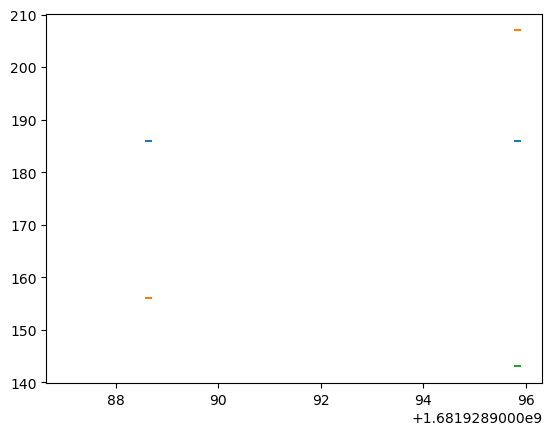

In [110]:
# see topic names in column
for name in csv_data.columns:
    if "/perception/object_recognition/tracking/objects/objects.0/object_id" in name and not "covariance." in name:
        print(name)

# plot csv data
import matplotlib.pyplot as plt
plt.plot(csv_data[stamp_msgs[1]], csv_data["/perception/object_recognition/tracking/objects/objects.0/object_id/uuid.0"])
plt.plot(csv_data[stamp_msgs[1]], csv_data["/perception/object_recognition/tracking/objects/objects.1/object_id/uuid.0"])
plt.plot(csv_data[stamp_msgs[1]], csv_data["/perception/object_recognition/tracking/objects/objects.2/object_id/uuid.0"])


<AxesSubplot:xlabel='/perception/object_recognition/tracking/objects/header/stamp'>

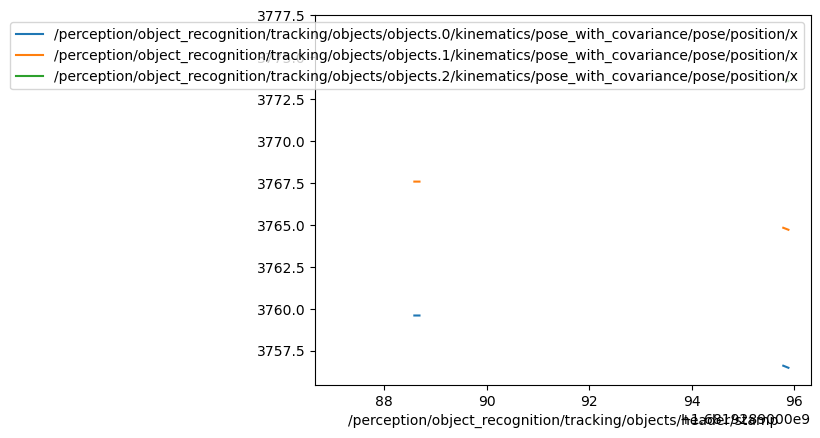

In [109]:
# plot x position of trackers
csv_data.plot(x = stamp_msgs[1],
              y=["/perception/object_recognition/tracking/objects/objects.0/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/tracking/objects/objects.1/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/tracking/objects/objects.2/kinematics/pose_with_covariance/pose/position/x"])

<AxesSubplot:xlabel='/perception/object_recognition/detection/objects/header/stamp'>

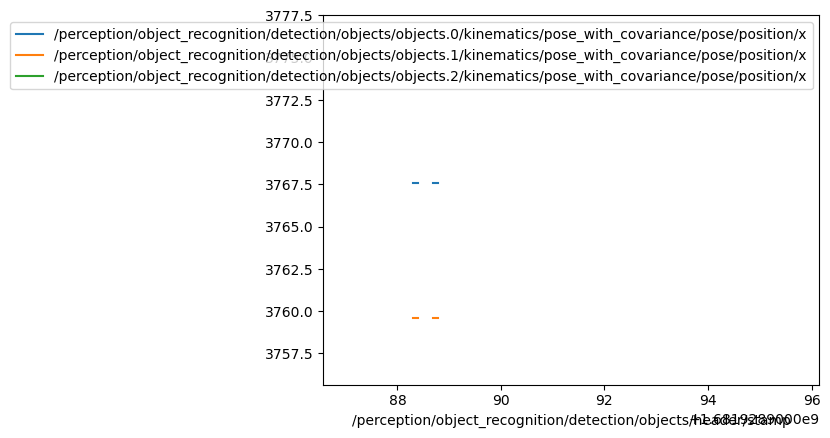

In [114]:
# plot x position of trackers
csv_data.plot(x = stamp_msgs[0],
              y=["/perception/object_recognition/detection/objects/objects.0/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/detection/objects/objects.1/kinematics/pose_with_covariance/pose/position/x",
                 "/perception/object_recognition/detection/objects/objects.2/kinematics/pose_with_covariance/pose/position/x"])

In [92]:
from iou_utils import get_2d_iou

get_2d_iou(test_detected_object, test_detected_object)

AttributeError: module 'tf2_ros' has no attribute 'transformations'